In [175]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats

import sys

In [176]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

Load interaction results:

In [177]:
res_all = pd.read_csv(os.path.join(data_path, 'processed', 'joint_ols_perm_interactions.csv'), 
                     index_col = 0)

Filter for significant interactions by permutation test:

In [178]:
alpha = 0.2
res_all = res_all[res_all.bh_fdr_perm <= alpha]

print('There are {} significant interactions'.format(res_all.shape[0]))

There are 31 significant interactions


Check for concordance between the OLS and permutation approach:

In [179]:
stats.spearmanr(res_all.coef_perm, 
                res_all.coef_OLS)

SignificanceResult(statistic=np.float64(0.39395161290322583), pvalue=np.float64(0.02831920552200202))

Identify which features occur in the most interactions:

In [180]:
feature_counts = pd.Series(res_all.feature_1.tolist() + res_all.feature_2.tolist()).value_counts()
feature_counts

ZCCHC13 (389874)    6
AXIN1 (8312)        5
GPHN (10243)        5
PA2G4 (5036)        4
APC (324)           4
POLR2A (5430)       3
CLEC4E (26253)      3
SEMG1 (6406)        3
ARRB2 (409)         3
SP1 (6667)          3
REL (5966)          2
STAT5B (6777)       2
EP300 (2033)        2
PCBP1 (5093)        2
ADAD1 (132612)      2
FPR2 (2358)         1
ACVR1B (91)         1
IL9 (3578)          1
ANAPC2 (29882)      1
TRAF6 (7189)        1
AKAP9 (10142)       1
BRCA1 (672)         1
CDK9 (1025)         1
C8A (731)           1
MRGPRX1 (259249)    1
NONO (4841)         1
NCKIPSD (51517)     1
STRN (6801)         1
Name: count, dtype: int64

Since we used feature sets, where the idea was to focus on modules of interactions, let's focus on these features that have multiple interactions:

In [181]:
multiple_interactions = feature_counts[feature_counts >= 2]
multiple_interactions

ZCCHC13 (389874)    6
AXIN1 (8312)        5
GPHN (10243)        5
PA2G4 (5036)        4
APC (324)           4
POLR2A (5430)       3
CLEC4E (26253)      3
SEMG1 (6406)        3
ARRB2 (409)         3
SP1 (6667)          3
REL (5966)          2
STAT5B (6777)       2
EP300 (2033)        2
PCBP1 (5093)        2
ADAD1 (132612)      2
Name: count, dtype: int64

In [182]:
res_multiple

,feature_1,feature_2,coef_perm,pval_perm,bh_fdr_perm,coef_OLS,t_statistic_OLS,feature_1_rank,feature_1_gene_name,feature_2_rank,feature_2_gene_name
0,REL (5966),GPHN (10243),-3.221476e-03,0.002,0.098000,-0.365096,4.265245,5040,REL,12963,GPHN
1,GPHN (10243),AXIN1 (8312),-3.557160e-03,0.012,0.164500,-0.263427,3.768648,12963,GPHN,12842,AXIN1
2,CLEC4E (26253),ADAD1 (132612),1.359538e-05,0.022,0.164500,60.411815,3.758878,827,CLEC4E,17918,ADAD1
3,AXIN1 (8312),PA2G4 (5036),-1.994186e-03,0.040,0.164500,-0.345529,3.479151,12842,AXIN1,4460,PA2G4
4,AXIN1 (8312),BRCA1 (672),-2.166259e-03,0.047,0.164500,-0.283360,3.396296,12842,AXIN1,5869,BRCA1
7,PA2G4 (5036),SP1 (6667),-1.739785e-03,0.094,0.164500,-0.315179,3.295095,4460,PA2G4,7313,SP1
8,ARRB2 (409),SP1 (6667),-3.015380e-03,0.051,0.164500,-0.219638,3.274340,8164,ARRB2,7313,SP1
9,ARRB2 (409),ANAPC2 (29882),-3.081827e-03,0.057,0.164500,-0.206739,3.217382,8164,ARRB2,18562,ANAPC2
10,ADAD1 (132612),ZCCHC13 (389874),6.066973e-08,0.074,0.164500,9569.068494,3.192012,17918,ADAD1,18946,ZCCHC13
12,ZCCHC13 (389874),SEMG1 (6406),1.475527e-06,0.037,0.164500,395.149617,3.164289,18946,ZCCHC13,5245,SEMG1


In [183]:
res_multiple = res_all[(res_all.feature_1.isin(multiple_interactions.index)) | (res_all.feature_1.isin(multiple_interactions.index))]
res_multiple.shape

(25, 11)

In [184]:
tuple_list = list(zip(res_multiple['feature_1'], res_multiple['feature_2']))
tuple_list = [i[0] + ' & ' + i[1] for i in tuple_list]
print(*tuple_list, sep = ', ')


REL (5966) & GPHN (10243), GPHN (10243) & AXIN1 (8312), CLEC4E (26253) & ADAD1 (132612), AXIN1 (8312) & PA2G4 (5036), AXIN1 (8312) & BRCA1 (672), PA2G4 (5036) & SP1 (6667), ARRB2 (409) & SP1 (6667), ARRB2 (409) & ANAPC2 (29882), ADAD1 (132612) & ZCCHC13 (389874), ZCCHC13 (389874) & SEMG1 (6406), STAT5B (6777) & SP1 (6667), PCBP1 (5093) & REL (5966), CLEC4E (26253) & SEMG1 (6406), POLR2A (5430) & ACVR1B (91), CLEC4E (26253) & ZCCHC13 (389874), APC (324) & PA2G4 (5036), ZCCHC13 (389874) & FPR2 (2358), APC (324) & AXIN1 (8312), PA2G4 (5036) & EP300 (2033), POLR2A (5430) & APC (324), POLR2A (5430) & GPHN (10243), PCBP1 (5093) & APC (324), ZCCHC13 (389874) & IL9 (3578), STAT5B (6777) & GPHN (10243), GPHN (10243) & STRN (6801)


# Biological Interpretation

https://chatgpt.com/share/67f6e776-d2c4-800b-85e0-bbaa27e490fb

# Topology Based Interpretation

In [119]:
from typing import Union, List
import networkx as nx

def flatten_list(list1) -> list:
    return [item for sublist in list1 for item in sublist]

def drop_duplicate_interactions(sn_ppis: pd.DataFrame, 
                             source_label: str = 'source_genesymbol',
                             target_label: str = 'target_genesymbol',
                             stimulation_label: str = 'consensus_stimulation',
                             inhibition_label: str = 'consensus_inhibition'):
    """Systematically aggregate any duplicate interactions between the source and target node. 

    Parameters
    ----------
    sn_ppis : pd.DataFrame
        an edge list representing the signaling network, output of `scLEMBAS.parse_network.load_network`
    source_label : str
        the column label for source nodes in the graph, by default 'source_genesymbol'
    target_label : str
        the column label for the target node in the graph, by default 'target_genesymbol'
    stimulation_label : str, optional
        column name of stimulating interactions, see `sn_ppis`, by default 'consensus_stimulation'
    inhibition_label : str, optional
        column name of inhibitory interactions, see `sn_ppis`, by default 'consensus_inhibition'

    Returns
    -------
    sn_ppis : pd.DataFrame
        a copy of the input interaction network with duplicates aggregated
    """

    sn_ppis = sn_ppis.copy()
    duplicated_interactions = sn_ppis[sn_ppis.duplicated(subset = [source_label, target_label], keep='first')].drop_duplicates(subset = [source_label, target_label])
    unique_vals = pd.DataFrame(columns = sn_ppis.columns)
    drop_indeces = []
    for idx in tqdm(duplicated_interactions.index):
        source = duplicated_interactions.loc[idx, source_label]
        target = duplicated_interactions.loc[idx, target_label]

        dup_int = sn_ppis[(sn_ppis[source_label] == source) & (sn_ppis[target_label] == target)].copy()
        drop_indeces += dup_int.index.tolist()
        dup_int.reset_index(inplace = True, drop = True)

        if (dup_int[[source_label, target_label, stimulation_label, inhibition_label, 'n_references', 'curation_effort', 'references' ]].nunique() == 1).all():
            dup_int = pd.DataFrame(dup_int.iloc[0, :]).T
        else:
            # filter by n_references
            dup_int = dup_int[dup_int.n_references == dup_int.n_references.max()]
            # filter by curation effort
            if dup_int.shape[0] > 1:
                dup_int = dup_int[dup_int.curation_effort == dup_int.curation_effort.max()]
            # merge remaining
            if dup_int.shape[0] > 1:
                if dup_int[stimulation_label].nunique() > 1:
                    dup_int[stimulation_label] = False
                if dup_int[inhibition_label].nunique() > 1:
                    dup_int[stimulation_label] = False
                references = sorted(set(flatten_list([ref.split(';') if not (type(ref) == float and np.isnan(ref)) else [ref] for ref in dup_int.references.tolist()])))
                references = [ref for ref in references if not (type(ref) == float and np.isnan(ref))]
                n_references = len(references)
                dup_int = dup_int.iloc[0, :]
                dup_int['n_references'] = n_references
                dup_int['references'] = ';'.join(references) if len(references) > 0 else np.nan
                dup_int = pd.DataFrame(dup_int).T
        if dup_int.shape[0] != 1:
            raise ValueError('There are still duplicated interactions')

        unique_vals = pd.concat([unique_vals, dup_int], axis = 0)

    sn_ppis.drop(index = drop_indeces, inplace = True)
    sn_ppis = pd.concat([sn_ppis, unique_vals], axis = 0)
    sn_ppis.reset_index(inplace = True, drop = True)
    if sn_ppis.duplicated(subset = [source_label, target_label]).any():
        raise ValueError('Interaction DB still has duplicates')

    return sn_ppis

def correct_moa(sn_ppis: pd.DataFrame,
                stimulation_label: str = 'consensus_stimulation',
                inhibition_label: str = 'consensus_inhibition'):
    """In the case where mode of action is True for both stimulating and inhibiting, make this an unknown MOA.

    Parameters
    ----------
    sn_ppis : pd.DataFrame
        an edge list representing the signaling network, output of `scLEMBAS.parse_network.load_network`
    stimulation_label : str, optional
        column name of stimulating interactions, see `sn_ppis`, by default 'consensus_stimulation'
    inhibition_label : str, optional
        column name of inhibitory interactions, see `sn_ppis`, by default 'consensus_inhibition'

    Returns
    -------
    sn_ppis : pd.DataFrame
        a copy of the input interaction network with duplicates aggregated
    """
    sn_ppis = sn_ppis.copy()
    sn_ppis.loc[sn_ppis[(sn_ppis[stimulation_label] == 1) & (sn_ppis[inhibition_label] == 1)].index, 
    [stimulation_label, inhibition_label]] = [False, False]
    
    return sn_ppis

def extract_network(sn_ppis: pd.DataFrame, 
                              curation_effort_thresh: int = 5, n_references_thresh: int = 3,
                              resources: Union[List, str] = 'all',
                            drop_self: bool = True,
                             source_label: str = 'source_genesymbol',
                             target_label: str = 'target_genesymbol',
                             verbose: bool = True):
    """Various filters on the ppi network.

    Parameters
    ----------
    sn_ppis : pd.DataFrame
        an edge list representing the signaling network
    curation_effort_thresh : int, optional
        threshold of curation effort to retain interaction, by default 5
    n_references_thresh : int, optional
        threshold of number of references to retain interaction, by default 3
    resources : Union[List, str], optional
        resources from which to retain interactions, by default 'all' which won't filter out resources
    drop_self : bool, optional
        get rid of self-interacting nodes, by default True
    source_label : str
        the column label for source nodes in the graph, by default 'source_genesymbol'
    target_label : str
        the column label for the target node in the graph, by default 'target_genesymbol'
    verbose : bool, optional
        print status of network extraction, by default True

    Returns
    -------
    sn_ppis : pd.DataFrame
        an edge list representing the filtered signaling network
    """

    n_int_a = sn_ppis.shape[0]
    
    sn_ppis = sn_ppis[(sn_ppis.n_references >= n_references_thresh) & (sn_ppis.curation_effort >= curation_effort_thresh)]
    if verbose:
        n_int_b = sn_ppis.shape[0]
        print('The thresholds filtered {}  of {} interactions'.format(n_int_a - n_int_b, n_int_a))
    
    if resources and resources != 'all':
        n_sources = sn_ppis.sources.apply(lambda x: len(set(x.split(';')).intersection(resources)))
        sn_ppis = sn_ppis[n_sources > 0]
        if verbose:
            n_int_c = sn_ppis.shape[0]
            print('The resources filtered {}  of {} interactions'.format(n_int_b - n_int_c, n_int_b))

    if drop_self:
        sn_ppis = sn_ppis[sn_ppis[[source_label, target_label]].apply(lambda x: x.nunique() == 2, axis = 1)]

    return sn_ppis

In [120]:
ppi_link = 'https://zenodo.org/records/11477837/files/organism_omnipath_ppi_05_24_24.csv'
organism = 'human'
sn_ppis = pd.read_csv(ppi_link.replace('organism', organism), index_col = 0) 

# some formatting and filtering
sn_ppis['n_references'] = sn_ppis.n_references.fillna(sn_ppis.n_references.min() - 1)
sn_ppis['curation_effort'] = sn_ppis.curation_effort.fillna(sn_ppis.curation_effort.min() - 1)

sn_ppis = drop_duplicate_interactions(sn_ppis)
sn_ppis = correct_moa(sn_ppis)
sn_ppis = extract_network(sn_ppis,
                curation_effort_thresh =  1, 
                n_references_thresh = 0, 
                resources = 'all', 
                drop_self = False)



  0%|                                                   | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_3895593/444149904.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_vals = pd.concat([unique_vals, dup_int], axis = 0)
100%|█████████████████████████████████████████| 493/493 [00:13<00:00, 36.47it/s]


The thresholds filtered 36590  of 133607 interactions


In [ ]:
G = nx.from_pandas_edgelist(sn_ppis, source_label, target_label,
                            create_using = nx.DiGraph() if sn_ppis[sn_ppis.is_directed].shape[0] == sn_ppis.shape[0] else None)
centrality = nx.degree_centrality(G)

In [185]:
interacting_genes = list(set(res_all.feature_1_gene_name.tolist() + res_all.feature_2_gene_name.tolist()))
network_genes = set(sn_ppis.source_genesymbol.tolist() + sn_ppis.target_genesymbol.tolist())

print('The following genes are not present in Omnipath')    
missing_genes = list(set(interacting_genes).difference(network_genes))
feature_counts.index = pd.Series(feature_counts.index).apply(lambda x: x.split(' (')[0]).tolist()

feature_counts.loc[missing_genes]

The following genes are not present in Omnipath


ZCCHC13    6
CLEC4E     3
ADAD1      2
Name: count, dtype: int64

In [214]:
feature_counts = pd.DataFrame(feature_counts)
feature_counts.rename(columns = {'count': 'n_interactions'}, inplace = True)
feature_counts['centrality'] = feature_counts.index.map(centrality)

<Axes: xlabel='n_interactions', ylabel='centrality'>

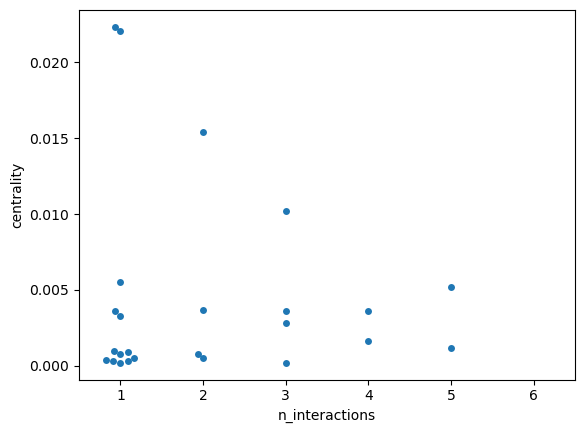

In [221]:
sns.swarmplot(data = feature_counts, x = 'n_interactions', y = 'centrality')

In [235]:
stats.spearmanr(feature_counts[feature_counts.centrality.notna()].n_interactions, 
                feature_counts[feature_counts.centrality.notna()].centrality)

SignificanceResult(statistic=np.float64(0.20099718939461514), pvalue=np.float64(0.33533931128634287))

In [222]:
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)
# model_coefs['rank'] = range(model_coefs.shape[0])

model_coefs['interacting'] = False
interacting_features = list(set(res_all.feature_1.tolist() + res_all.feature_2.tolist()))
model_coefs.loc[interacting_features, 'interacting'] = True
model_coefs['centrality'] = model_coefs.gene_name.map(centrality)
model_coefs = model_coefs[model_coefs.centrality.notna()]

<Axes: xlabel='interacting', ylabel='centrality'>

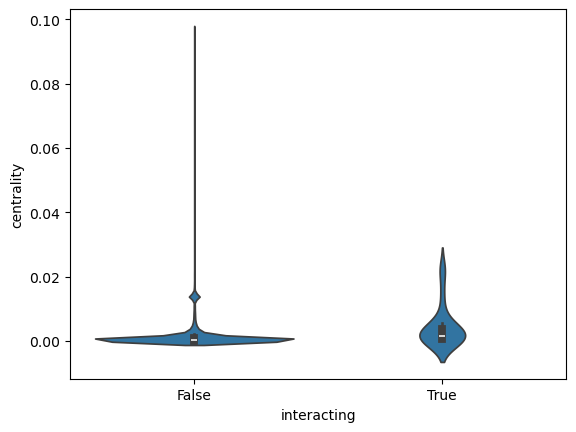

In [225]:
sns.violinplot(data = model_coefs, x = 'interacting', y = 'centrality')

In [226]:
stats.mannwhitneyu(model_coefs[model_coefs.interacting]['centrality'], 
                  model_coefs[~model_coefs.interacting]['centrality'], 
                  alternative = 'greater')

MannwhitneyuResult(statistic=np.float64(176991.5), pvalue=np.float64(2.648297937688177e-06))

In [ ]:
import sys
sys.path.insert(1, '../../')
from utils import cohen_d

In [231]:
cohen_d(model_coefs[model_coefs.interacting]['centrality'], 
                  model_coefs[~model_coefs.interacting]['centrality'])

# TODO: cliff's delta

np.float64(0.6811605252306309)